In [1]:
# Importing libraries
from data_driven.modeling.scripts.tuning import rfc_parameter_tuning
from data_driven.modeling.scripts.ancillary import (drive_authentication, npz_files, open_dataset,
                                                    cv_and_y_random, save_best_params,
                                                   rfc_draw_convergence)
from data_driven.modeling.scripts.evaluation import performing_cross_validation, data_driven_models_ranking
from data_driven.modeling.scripts.metrics import prediction_evaluation

%matplotlib inline
from skopt.space import Integer, Categorical
import pandas as pd
import time
from sklearn.metrics import plot_confusion_matrix
import pickle
import os
import matplotlib.pyplot as plt
import time

2022-03-04 02:38:07.712489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 02:38:07.712522: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Accessing the data 

If you will use Google Drive, you have to enable Google Drive and obtain the client secrets file client_secrets.json (see the following [link](https://developers.google.com/drive/api/v3/enable-drive-api) or [this other](https://www.geeksforgeeks.org/get-list-of-files-and-folders-in-google-drive-storage-using-python/))

In [2]:
# Connecting to Google Drive
# client_secrets.json need to be in the same directory as the script

drive = drive_authentication()

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=128273080156-gak8id4v61mj7jjdqqucv74kc5volhj0.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


If you need to check the folder on where you have stored the data for running the multi-class classification algorithm, use the folder ID and the function just below

In [3]:
# When you share a folder/file from Google Drive by using its shareable link you will see tomething like 
# https://drive.google.com/drive/folders/{ID_element}?usp=sharing. You can take the ID_element

multi_label_data_folder_id = '1yt28k8qTS0ZXglXYkUILSCeqodzZEJ4R'
ids = npz_files(multi_label_data_folder_id, drive)
ids

{'4': '1EcrEiDvZeTfYpC7jng2CYZx53Saf68P2',
 '5': '1gpVvE9ma8Am1K6SSCYzy3r8TRVJ7kV2w',
 '6': '1RcsI3VNa29k990N6HUOQiLECHWhjhEvl'}

# 2. Building RFC with default parameters

In [4]:
# Default parameters
model_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 200,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_jobs': 4,
    'oob_score': False,
    'random_state': 0,
    'verbose': 0,
    'warm_start': False,
}

In [6]:
df_results = pd.DataFrame()

for id, key in ids.items():
    
    print(f'Evaluating base model for data preparation id {id}\n')
    
    # Opening the dataset
    X_train, Y_train = open_dataset(id, key, drive, test=False)
    
    # Y-randomization and cross-validation
    start = time.time()
    df_temporary = cv_and_y_random(id, X_train, Y_train,
                                            model_params, 'RFC', 'multi-label classification',
                                            threshold=0.75
                                            )
    end = time.time()
    df_temporary['time_sec'] = end - start
    df_temporary['n_samples'] = X_train.shape[0]
    df_temporary['n_bytes'] = X_train.nbytes
    
    df_results = pd.concat([df_results,
                            df_temporary
                           ],
                          axis=0,
                          ignore_index=True)

Evaluating base model for data preparation id 4

X train has the following dimensions: (285888, 87)
Y train has the following dimensions: (285888, 10)


5-fold cross validation:   0%|                                                                                                                                                       | 0/5 [00:00<?, ?it/s]2022-02-23 18:37:28.050385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-23 18:37:28.050425: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-23 18:37:28.050451: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jodhernandezbe-X399-AORUS-PRO): /proc/driver/nvidia/version does not exist
2022-02-23 18:37:28.051349: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical oper

Evaluating base model for data preparation id 5

X train has the following dimensions: (285578, 87)
Y train has the following dimensions: (285578, 10)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:33<00:00, 39.32s/it]


Evaluating base model for data preparation id 6

X train has the following dimensions: (286112, 97)
Y train has the following dimensions: (286112, 10)


Y-Randomization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:26<00:00, 38.69s/it]


In [7]:
df_results

,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error,y_randomization_mean_0_1_loss_or_error,y_randomization_std_0_1_loss_or_error,id,time_sec,n_samples,n_bytes
0,0.68,0.98,over-fitting (high variance),0.72,0.98,0.45,0.001664,1.0,0.000266,4,5938.614402,285888,198978048
1,0.67,0.98,over-fitting (high variance),0.71,0.98,0.46,0.001416,1.0,0.000245,5,3926.824423,285578,198762288
2,0.67,0.98,over-fitting (high variance),0.71,0.98,0.46,0.001924,1.0,0.000323,6,3902.783124,286112,222022912


In [8]:
# Saving results

cv_path = os.path.join(os.getcwd(),
                        os.pardir,os.pardir,
                        'output', 'base_evaluation',
                        'multi-label classification'.replace(' ', '_'),
                        'base_results.csv')
df_results.to_csv(cv_path, index=False)

The above results show that multi-label models, which consider that the categories are not mutually exclusive, perform better than multi-class models. Even the base RFC performs better than the tuned multi-class one.

# 3. Selection of best data preprocessing

Model performance, explainability, and time are three important factors to be considered.

1. Explainability: from the point of view of the model, as the three pipelines use RFC, the explainability depends on the features. FAMD reduces the dimensionality by transforming the original features into new orthogonal ones. Thus, it is not possible to make inferences directly about the importance of the original feature. For this cretirion, the pipelines 5 and 6 are a better options.
2. Performance: as shown in the above results, the default RFC presents overfitting for the three preprocessing pipelines and their performances are similar, with the pipeline id 4 a little better than the others.
3. Time: for Y randomization and cross validation, the pipeline id 6 required around 0.0066 sec/samples. This pepilene could represent the lower time per sample for tuning and prediction for serving models.

## 3.1 FAHP



In [ ]:
# Run this if you require

cv_path = os.path.join(os.getcwd(),
                        os.pardir,os.pardir,
                        'output', 'base_evaluation',
                        'multi-label classification'.replace(' ', '_'),
                        'base_results.csv')
df_results = pd.read_csv(cv_path)
df_results

In [11]:
# Applyting FAHP

df_results['id'] = df_results['id'].astype('int')
df_results['model_explainability'] = 1
df_results['dimensionality_reduction_explainability'] = df_results['id'].map({4: 0, 5: 1, 6: 1})

df_results['weight'] = data_driven_models_ranking(df_results)

df_results['rank'] = df_results['weight'].rank(method='dense', ascending=False).astype(int)

df_results

,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error,y_randomization_mean_0_1_loss_or_error,y_randomization_std_0_1_loss_or_error,id,...,model_explainability,dimensionality_reduction_explainability,criterion_1,criterion_2,criterion_3,criterion_4,criterion_5,criterion_6,weight,rank
0,0.68,0.98,over-fitting (high variance),0.72,0.98,0.45,0.001664,1.0,0.000266,4,...,1,0,0.666667,0.72,-0.000000,1.00000,1,0,0.292698,3
1,0.67,0.98,over-fitting (high variance),0.71,0.98,0.46,0.001416,1.0,0.000245,5,...,1,1,0.666667,0.71,0.822447,0.00358,1,1,0.340652,2
2,0.67,0.98,over-fitting (high variance),0.71,0.98,0.46,0.001924,1.0,0.000323,6,...,1,1,0.666667,0.71,1.000000,-0.00000,1,1,0.366650,1


As shown above, the data preparation pipeline id 6 is the best one for multi-label classification.

# 4. Tuning the model

In [3]:
# Opening the dataset
X_train, Y_train, X_test, Y_test = open_dataset('6', '1RcsI3VNa29k990N6HUOQiLECHWhjhEvl', drive, test=True)

X train has the following dimensions: (286112, 97)
Y train has the following dimensions: (286112, 10)
X test has the following dimensions: (38844, 97)
Y test has the following dimensions: (38844, 10)


In [4]:
# Fixed parameters
model_params = {
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_weight_fraction_leaf': 0.0,
    'n_jobs': 4,
    'oob_score': False,
    'random_state': 0,
    'verbose': 0,
    'warm_start': False,
}

In [5]:
# For tuning
search_space = [Integer(1, 50, name='min_samples_leaf'),
                Integer(2, 50, name='min_samples_split'), 
                Categorical(['log2', 'sqrt'], name='max_features'),
                Integer(10, 500, name='n_estimators'),
                Integer(5, 200, name='max_depth'),
                Categorical(['gini', 'entropy'], name='criterion'),
                Categorical([True, False], name='bootstrap')]

In [6]:
# Initial points

x_initial = {'min_samples_leaf': 1,
            'min_samples_split': 2,
            'max_features': 'sqrt',
            'n_estimators': 100,
            'max_depth': 200,
            'criterion': 'gini',
            'bootstrap': True}
y_initial = -0.71

In [7]:
# Tuning
# We run Bayesian Optimization with Gaussian Processes, which uses a Multidimensional Gaussian distribution as surrogate model.
# The objective function is the negative of the the mean f1 score for 5-fold cross-validation
# A threshold of 0.75 for the f1 score to stop the optimization is used
# n_iter_search = number of iterations for the Bayesian Optimization
# time_to_optimize = the budget time to optimize the Bayesian Optimization

start = time.time()

tuning_result = rfc_parameter_tuning(X_train, Y_train,
                                'multi-label classification',
                                model_params, search_space,
                                time_to_optimize=14400,
                                n_calls=200,
                                threshold=0.75, 
                                verbose=False,
                                x_initial=x_initial,
                                y_initial=y_initial,
                                n_initial_points=5)

end = time.time()

model_params.update(tuning_result['best_params'])
best_params = {'model': {
                    'RFC': {'params': model_params
                           }
                        }
              }

# Saving the best parameters
save_best_params('multi-label classification', best_params)

print(f'The minimum for the objective function is {tuning_result["best_objective"]}')
print(f'The time actually spent for tuning {end - start} seconds')  

The minimum for the objective function is 0.71
The time actually spent for tuning 12831.8292491436 seconds


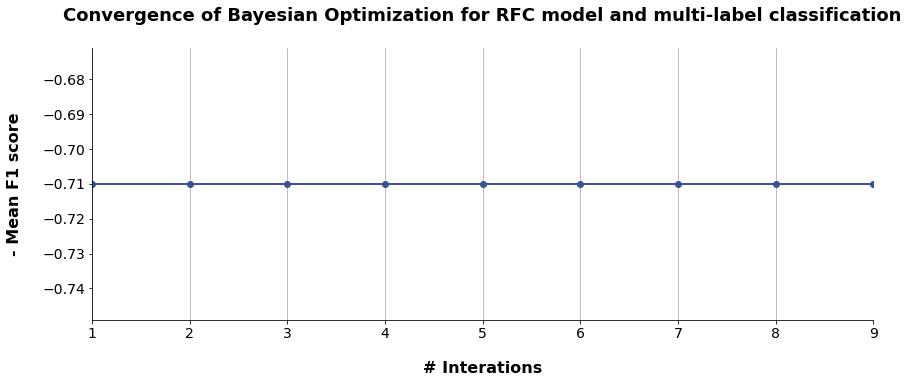

In [8]:
# Convergence drawing

rfc_draw_convergence(tuning_result, 'multi-label classification')

In [9]:
# cross-validation with the found hyperparameters

path_pickle = os.path.join(os.getcwd(),
                        os.pardir,os.pardir,
                        'output', 'models',
                        'multi-label classification'.replace(' ', '_'),
                        'RFC_best_params.pkl')

with open(path_pickle, 'rb') as inputfile:
    best_params = pickle.load(inputfile)['model']['RFC']['params']

In [10]:
cv_result, classifier = performing_cross_validation('RFC', best_params,
                                                    X_train, Y_train,
                                                    'multi-label classification',
                                                    for_tuning=False, threshold=0.75,
                                                    return_model=True)

5-fold cross validation:   0%|                                                                                                                                                       | 0/5 [00:00<?, ?it/s]2022-03-04 06:36:21.698426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-04 06:36:21.698460: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-04 06:36:21.698481: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jodhernandezbe-X399-AORUS-PRO): /proc/driver/nvidia/version does not exist
2022-03-04 06:36:21.699214: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical oper

In [11]:
pd.DataFrame({key: [val] for key, val in cv_result.items()})

,mean_validation_accuracy,mean_train_accuracy,accuracy_analysis,mean_validation_f1,mean_train_f1,mean_validation_0_1_loss_or_error,std_validation_0_1_loss_or_error
0,0.67,0.98,over-fitting (high variance),0.71,0.98,0.46,0.00183


In [12]:
# External evaluation

Y_test_hat = classifier.predict(X_test)

print(f'Test accuracy is {prediction_evaluation(Y_test, Y_test_hat)}')
print(f'Test f1 score is {prediction_evaluation(Y_test, Y_test_hat, metric="f1")}')

Test accuracy is 0.4064194858074188
Test f1 score is 0.4566205305196337


In [13]:
# Saving model
path_model = os.path.join(os.getcwd(),
                        os.pardir,os.pardir,
                        'output', 'models',
                        'multi-label classification'.replace(' ', '_'),
                        'RFC_model.pkl')
pickle.dump(classifier, open(path_model, 'wb'))